In [261]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from grad_cam import make_attention_map
from preprocess import preprocess_image
from torchvision import models
from utils import *
from classifier import *
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid", {'grid.linestyle': '--'})
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model16 = models.vgg16(pretrained=True)
model19 = models.vgg19(pretrained=True)

In [3]:
input_dir = '../data/input_images'
output_dir = '../data/output_images'

In [256]:
org_path = os.path.join(input_dir, 'bird.JPEG')
adv_path = os.path.join(output_dir, 'org_13_adv_839_adv.png')
noise_path = os.path.join(output_dir, 'org_13_adv_839_adv_noise.png')

save_dir = '/home/lab/takato/Documents/course/ml_murata/report/develop/data/figs'

## Make Attention Map

In [293]:
def attention_map(org_cam, adv_cam, org_label, adv_label, save_path):
    fontsize = 13
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(org_cam)
    ax1.axis('off')
    ax1.set_title(f'Original Image (label : {org_label})', fontsize=fontsize)
    ax2.imshow(adv_cam)
    ax2.axis('off')
    ax2.set_title(f'Adversarial Image (label : {adv_label})', fontsize=fontsize)
    plt.savefig(save_path, bbox_inches='tight')

In [281]:
path = [org_path, adv_path]
target_index = [13, 839]
labels = ['snow bird', 'suspension bridge']
save_path = os.path.join(save_dir, 'attentinon_13_839.png')

In [276]:
cam = []
for i_path, t in zip(path, target_index):
    i_cam = make_attention_map(path = i_path, use_cuda=False, target_index=t)
    cam.append(i_cam)

/home/lab/takato/.pyenv/versions/anaconda3-4.3.1/envs/ubuntu/lib/python3.6/site-packages/torch/autograd/__init__.py:93: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


In [275]:
cam[0].shape

(224, 224, 3)

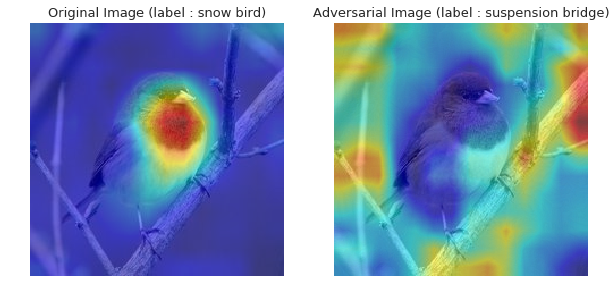

In [294]:
attention_map(cam[0], cam[1], labels[0], labels[1], save_path)

In [91]:
labels = read_labels('../data/labels.json')

## Augumentation

In [145]:
seq = iaa.Sequential([
    iaa.SomeOf(3, [
        iaa.Superpixels(p_replace=0.5, n_segments=100),
        iaa.GaussianBlur(0, 2.0),
        iaa.BilateralBlur(5, sigma_color=250, sigma_space=250),
        iaa.Sharpen(alpha=1),
        iaa.Emboss(alpha=1),
        iaa.AdditiveGaussianNoise(scale = 0.1 * 255),
    ])
],  random_order=True) # apply augmenters in random order

In [232]:
save_dir = '/home/lab/takato/Documents/course/ml_murata/report/develop/data/figs'

In [295]:
seq = iaa.Sequential([
        iaa.GaussianBlur(2.0),
        iaa.BilateralBlur(7, sigma_color=250, sigma_space=250),
        iaa.Sharpen(alpha=1),
        iaa.Emboss(alpha=1),
        iaa.Superpixels(p_replace=0.5, n_segments=100),
        iaa.AdditiveGaussianNoise(scale = 0.1 * 255)
],  random_order=True) # apply augmenters in random order

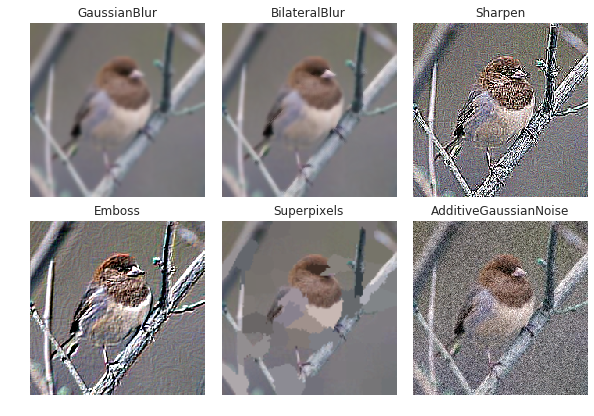

In [297]:
image = cv2.imread(adv_path, 1)
nrows  = 2
ncols = 3
title = ['GaussianBlur', 'BilateralBlur', 'Sharpen', 'Emboss', 'Superpixels', 'AdditiveGaussianNoise']
fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10, 10))
for i in range(6):
    row = int(i/ncols)
    col = 0 if (i % ncols) == 0 else col + 1
    iax = ax[row, col]
    
    iax.imshow(seq[i].augment_image(image))
    iax.axis("off")
    iax.set_title(title[i])
plt.subplots_adjust(left=None, bottom=0.1, right=None, top=0.65, wspace=0.1, hspace=0)
top = fig.subplotpars.top
wspace = fig.subplotpars.wspace
path = os.path.join(save_dir, 'filter.png')
plt.savefig(path, bbox_inches='tight')

In [142]:
image = cv2.imread(adv_path, 1)
img = seq.augment_image(image)

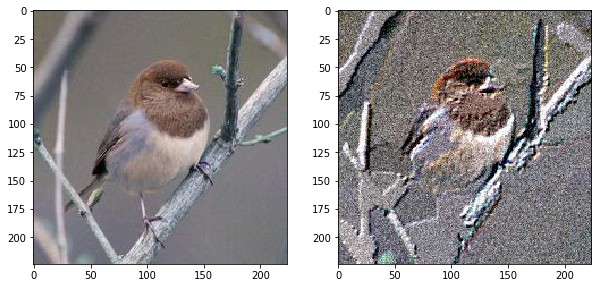

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[1].imshow(img)

## Classify test

In [238]:
C = Classifier(filter_=False)
labels = read_labels('../data/labels.json')

reading vgg16 ...


In [257]:
image = cv2.imread(noise_path, 1)
out, _ = C.forward(image)
_, label = out.data.max(1)
label = label.numpy()[0]
conf = nn.functional.softmax(out)[0][label].data.numpy()
pred = np.where(conf == max(conf))[0][0]

print(label, labels[str(label)], conf)

824 stole [0.42642805]


/home/lab/takato/.pyenv/versions/anaconda3-4.3.1/envs/ubuntu/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [243]:
image = cv2.imread(org_path, 1)
out, _ = C.forward(image)
_, label = out.data.max(1)
label = label.numpy()[0]
conf = nn.functional.softmax(out)[0][label].data.numpy()
pred = np.where(conf == max(conf))[0][0]

print(label, labels[str(label)], conf)

13 junco, snowbird [0.9979706]


/home/lab/takato/.pyenv/versions/anaconda3-4.3.1/envs/ubuntu/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


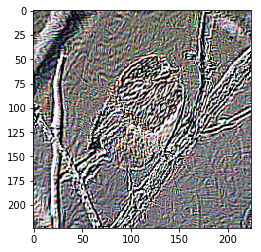

pred 84


/home/lab/takato/.pyenv/versions/anaconda3-4.3.1/envs/ubuntu/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


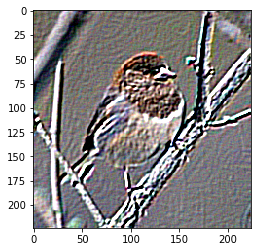

pred 84


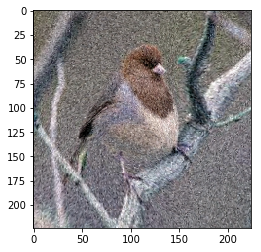

pred 105


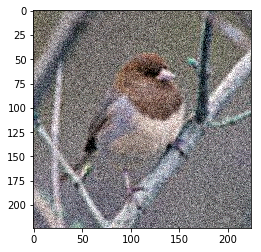

pred 105


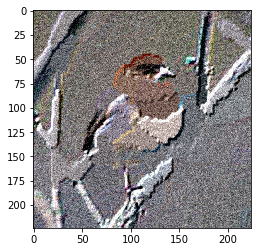

pred 105


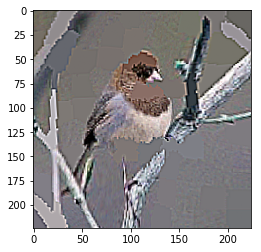

pred 105


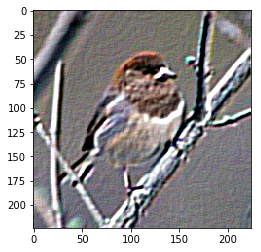

pred 105


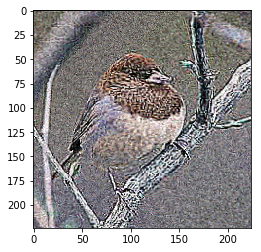

pred 84


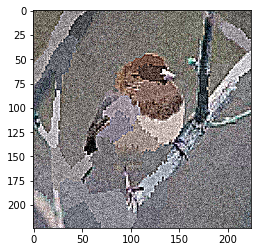

pred 84


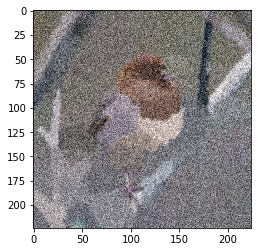

pred 84


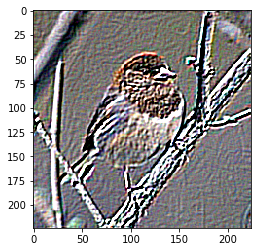

pred 84


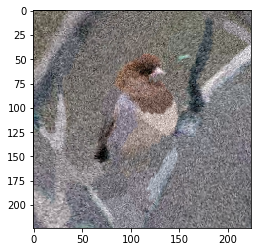

pred 84


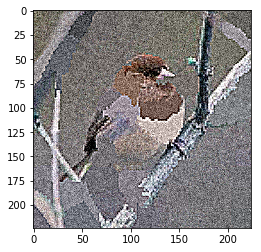

pred 84


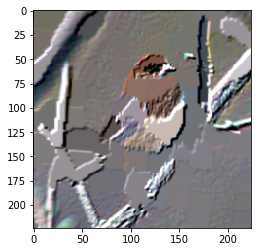

pred 84


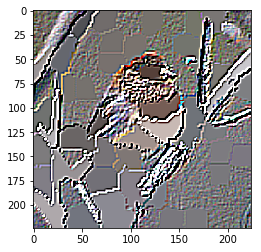

pred 84


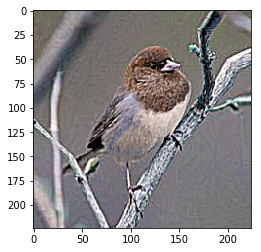

pred 84


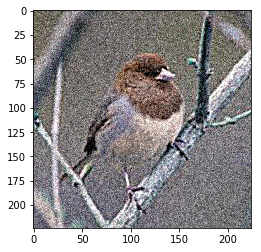

pred 13


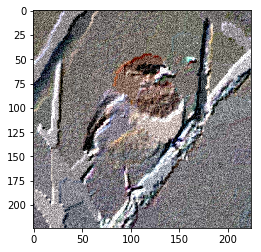

pred 13


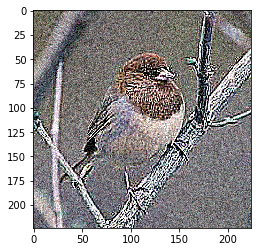

pred 84


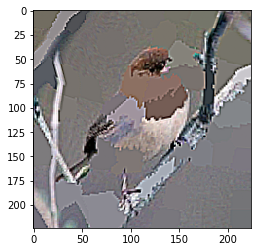

pred 84


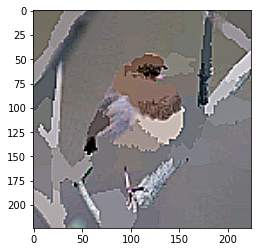

pred 84


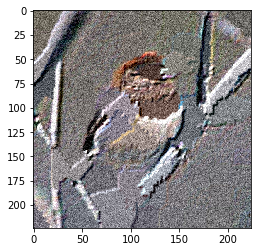

pred 84


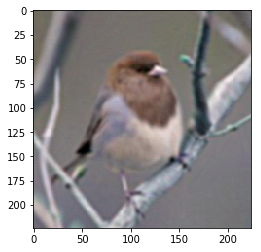

pred 13


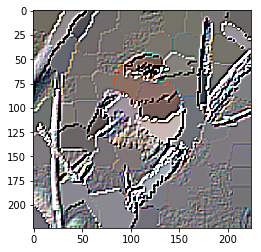

pred 13


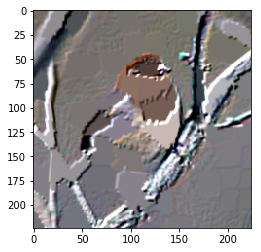

pred 13


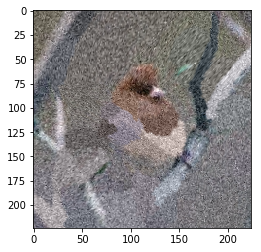

pred 13


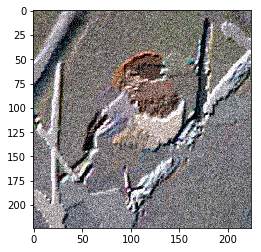

pred 13


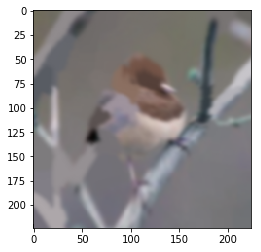

pred 13


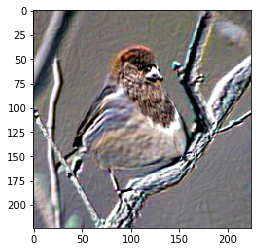

pred 13


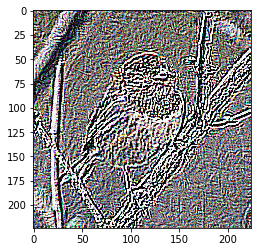

pred 13


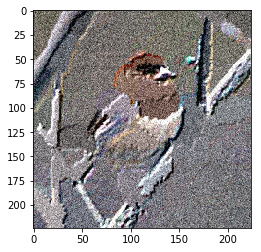

pred 13


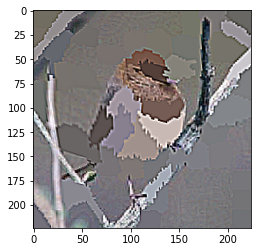

pred 13


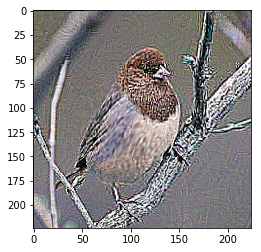

pred 13


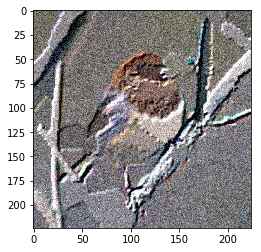

pred 13


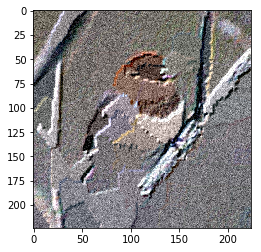

pred 13


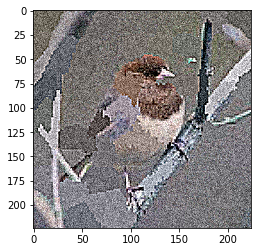

pred 13


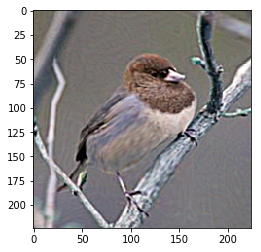

pred 13


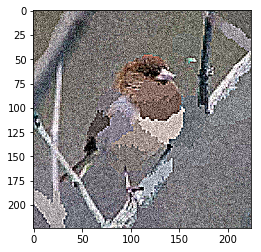

pred 13


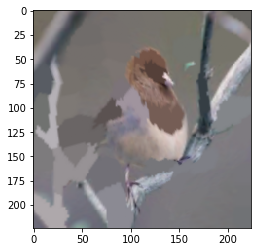

pred 13


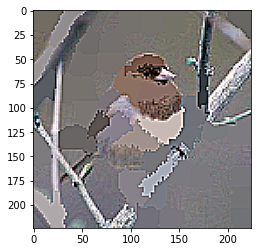

pred 13


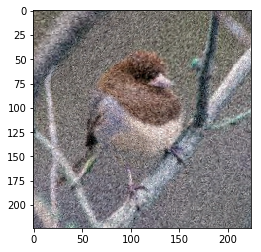

KeyboardInterrupt: 

In [112]:
image = cv2.imread(adv_path, 1)
conf = np.zeros([1000])
for i in range(100):
    img = seq.augment_image(image)    
    plt.imshow(img)
    plt.show()
    out, _ = C.forward(img)
    _, label = out.data.max(1)
    label = label.numpy()[0]
    conf += nn.functional.softmax(out)[0].data.numpy()
    pred = np.where(conf == max(conf))[0][0]
    print(f'pred {pred}')
#     print(label, labels[str(label)], conf, conf_a)

## RGB Histogram

In [235]:
def show_save(show, save, save_path):
    if save:
        plt.savefig(save_path, bbox_inches='tight')        
    else:
        pass
    
    if show:
        plt.show()

In [258]:
def make_rgb_histogram(org_image, adv_image, show=True, save=False, save_path=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(20, 5))
    fontsize = 20
    labelsize = 15
    color = ('r','g','b')
    histr_max_ = []
    for channel, col in enumerate(color):
        histr1 = cv2.calcHist([org_image], [channel], None, [256], [0,256])
        histr2 = cv2.calcHist([adv_image], [channel], None, [256], [0,256])
        histr_max_.extend([max(histr1), max(histr2)])
        # plot hist
        ax1.plot(histr1, color = col, label = col.upper())
        ax2.plot(histr2, color = col, label = col.upper())
        
    ax1.set_xlim([0,256])
    ax1.set_ylim(0, max(histr_max_) + 150)
    ax1.set_title('RGB Histogram (Original Image)', fontsize=fontsize)
    ax1.legend(fontsize = 18)
    ax1.tick_params(labelsize=labelsize)
    
    ax2.set_xlim([0,256])
    ax2.set_ylim(0, max(histr_max_) + 150)    
    ax2.set_title('RGB Histogram (Adversarial Image)', fontsize=fontsize) 
    ax2.legend(fontsize = 18)
    ax2.tick_params(labelsize=labelsize)
    
    show_save(show, save, save_path)    

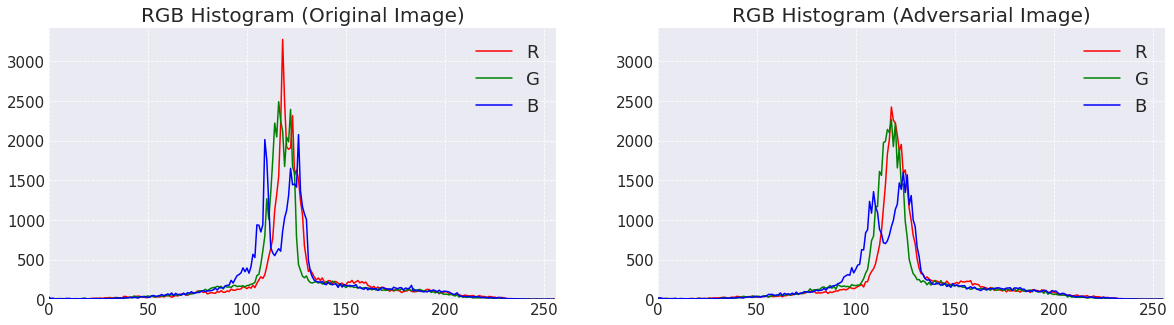

In [259]:
org_image = cv2.imread(org_path, 1)
adv_image = cv2.imread(adv_path, 1)
save_path = os.path.join(save_dir, 'rgb_hist.png')
make_rgb_histogram(org_image, adv_image, save=True, save_path=save_path)